In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import shutil

In [ ]:
from google.colab import files
import os
import zipfile
import io

### **Image Augmentation**

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.5), # vertically flip 20% of all images
        
         # Apply affine transformations to some of the images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-10, 10),
            shear=(-5, 5),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),
     
        # Execute 0 to 5 of the following (less important) augmenters per image.
        iaa.SomeOf((0, 3),
            [
                iaa.OneOf([
                    iaa.GaussianBlur((0, 2.0)),
                    iaa.AverageBlur(k=(2, 5)),
                    iaa.MedianBlur(k=(3, 5)),
                ]),

                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.LinearContrast((0.5, 2.0), per_channel=0.5),

                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [ ]:
#shutil.rmtree('defective')

In [ ]:
uploaded = files.upload()
os.listdir('.')

Saving defective.zip to defective.zip


['.config', 'defective.zip', 'sample_data']

In [ ]:
zf = zipfile.ZipFile(io.BytesIO(uploaded['defective.zip']), "r")
zf.extractall()
os.listdir('.')

['.config', 'defective', 'defective.zip', 'sample_data']

In [ ]:
def get_img_bbs_pairs():
    def get_annotations_list(path):
      file = open(path)
      annotations = [list(map(float, line[:-1].split(" "))) for line in file]
      file.close
      return annotations

    images = [cv2.imread('defective/images/'+str(i)+'.jpg') for i in range(1,27)]
    annotations = [get_annotations_list('defective/annotations/'+str(i)+'.txt') for i in range(1,27)]
    
    def convert_to_pixel(annotations, shape):
      new_annot = []
      for annot in annotations:
        _, x_center, y_center, width, height = annot
        x1, y1, x2, y2 = int((x_center - width)*shape[1]), int((y_center-height)*shape[0]), int((x_center+width)*shape[1]), int((y_center+height)*shape[0])
        new_annot.append([_, x1, y1, x2, y2])
      return new_annot 

    annotations_new = []
    for i in range(len(images)):
      shape = images[i].shape
      annotations_new.append(convert_to_pixel(annotations[i], images[i].shape))

    return images, annotations_new

In [ ]:
imgs, annots = get_img_bbs_pairs()

def image_sequence(imgs, annots, seq, n_img):
    images = np.array(
      [imgs[seq] for _ in range(n_img)],
      dtype=np.uint8
    )

    bbs = [BoundingBoxesOnImage([
        BoundingBox(x1=annot[1], y1=annot[2], x2=annot[3], y2=annot[4]) for annot in annots[seq]
    ], shape=images[_].shape)  for _ in range(n_img)]

    return images, bbs

images, bbs = image_sequence(imgs, annots, 1, 4)

In [ ]:
augmented_images, augmented_annotations = [], []
for i in range(26):
   images, bbs = image_sequence(imgs, annots, i, 10)
   images_aug, bbs_aug = seq(images=images, bounding_boxes=bbs)
   augmented_images.append(images_aug)
   augmented_annotations.append(bbs_aug)

<Figure size 432x288 with 0 Axes>

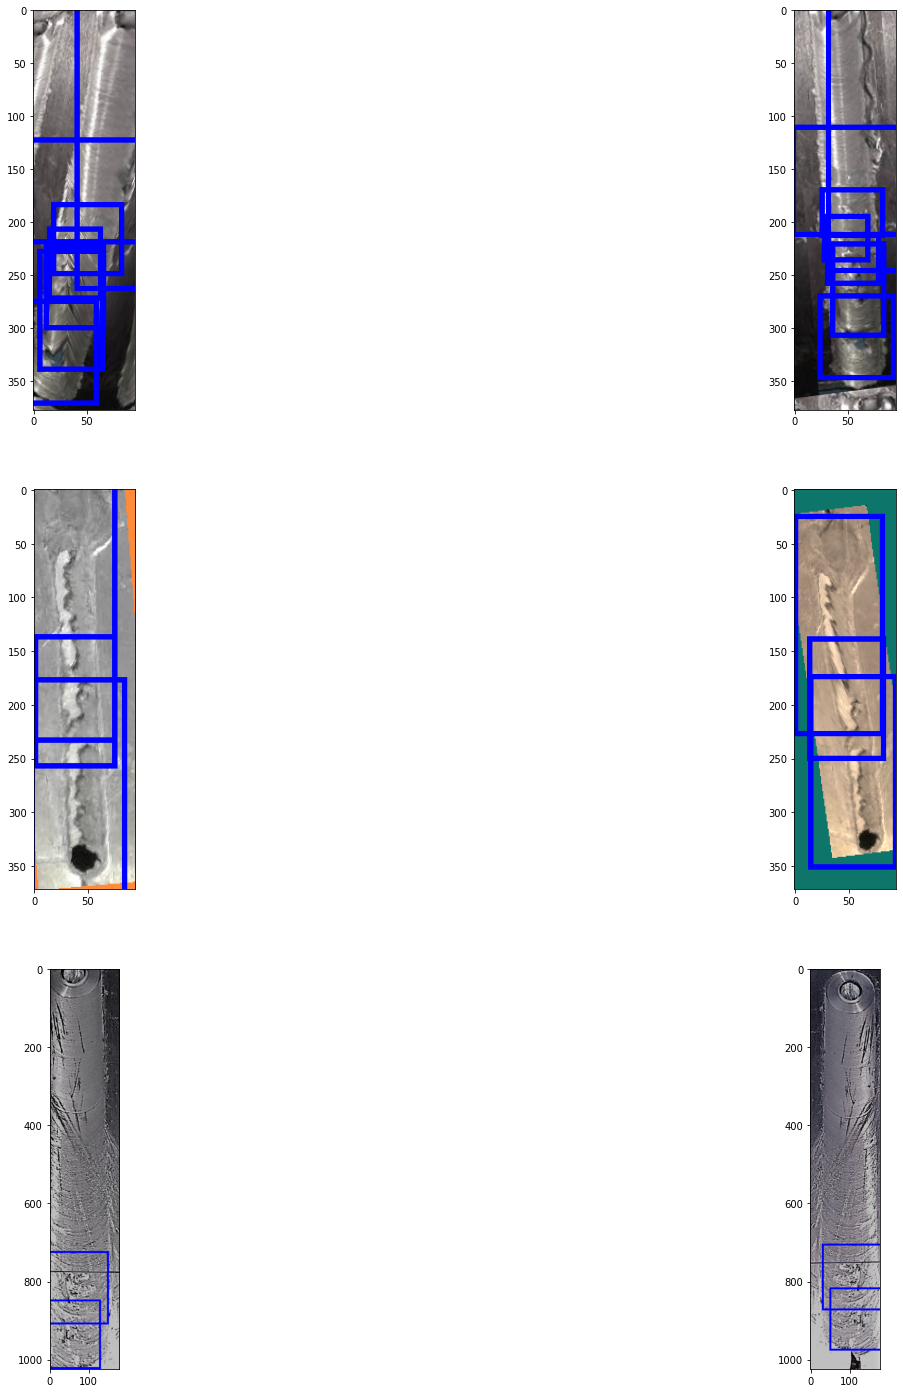

In [ ]:
plt.figure()

f, axarr = plt.subplots(3,2, figsize=(25,25)) 

for i in range(23, 26):
  for j in range(2):
    axarr[i-23, j%2].imshow(augmented_annotations[i][j].draw_on_image(augmented_images[i][j], size=5,  color=[0, 0, 255]))

In [ ]:
count = 1
import os
if not os.path.exists('new_images/annotations'):
    os.makedirs('new_images/annotations')
if not os.path.exists('new_images/images'):
    os.makedirs('new_images/images')

for i in range(len(augmented_images)):
  for j in range(len(augmented_images[i])):
    image = augmented_images[i][j]

    shape = image.shape

    with open('new_images/annotations/'+str(count)+'.txt', 'w') as writefile:
      for x in range(len(annots[i])):
        aug_annot = augmented_annotations[i][j].bounding_boxes[x]
        x1, y1, x2, y2 = aug_annot.x1, aug_annot.y1, aug_annot.x2, aug_annot.y2
        x1, x2= max(0, min(x1, shape[1])), max(0, min(x2, shape[1]))
        y1, y2= max(0, min(y1, shape[0])), max(0, min(y2, shape[0]))

        _, x_center, y_center, width, height = int(annots[i][x][0])-14, (x1+x2)/(2*shape[1]), (y1+y2)/(2*shape[0]), np.abs(x1-x2)/shape[1], np.abs(y1-y2)/shape[0]
        writefile.write("{} {} {} {} {}\n".format(_, x_center, y_center, width, height))    
    cv2.imwrite('new_images/images/'+str(count)+'.jpg', image)

    count += 1

In [ ]:
!zip -r new_images.zip new_images
files.download("new_images.zip")

  adding: new_images/ (stored 0%)
  adding: new_images/images/ (stored 0%)
  adding: new_images/images/17.jpg (deflated 1%)
  adding: new_images/images/88.jpg (deflated 1%)
  adding: new_images/images/121.jpg (deflated 2%)
  adding: new_images/images/219.jpg (deflated 1%)
  adding: new_images/images/184.jpg (deflated 1%)
  adding: new_images/images/204.jpg (deflated 2%)
  adding: new_images/images/131.jpg (deflated 1%)
  adding: new_images/images/174.jpg (deflated 2%)
  adding: new_images/images/10.jpg (deflated 1%)
  adding: new_images/images/209.jpg (deflated 1%)
  adding: new_images/images/230.jpg (deflated 1%)
  adding: new_images/images/16.jpg (deflated 1%)
  adding: new_images/images/140.jpg (deflated 2%)
  adding: new_images/images/231.jpg (deflated 1%)
  adding: new_images/images/137.jpg (deflated 1%)
  adding: new_images/images/90.jpg (deflated 0%)
  adding: new_images/images/146.jpg (deflated 1%)
  adding: new_images/images/126.jpg (deflated 2%)
  adding: new_images/images/20

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>